In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold
pd.set_option('display.max_colwidth', None)

import warnings
warnings.simplefilter('ignore')

In [3]:
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE


In [4]:
train=pd.read_csv('train_churn.csv')
test=pd.read_csv('test_churn.csv')
ss=pd.read_csv('sub_churn.csv')

In [5]:
train.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,84e2fcc9,36,Female,5L - 10L,563266.44,4,0,1,0,Average,1
1,57fea15e,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,0
2,8df34ef3,35,Female,More than 15L,701607.06,2,1,2,0,Poor,0
3,c5c0788b,43,Female,More than 15L,1393922.16,0,1,2,1,Poor,1
4,951d69c4,39,Female,More than 15L,893146.23,1,1,1,1,Good,1


In [6]:
test.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category
0,55480787,50,Female,More than 15L,1008636.39,2,1,2,1,Average
1,9aededf2,36,Male,5L - 10L,341460.72,2,0,2,1,Average
2,a5034a09,25,Female,10L - 15L,439460.10,0,0,2,1,Good
3,b3256702,41,Male,Less than 5L,28581.93,0,1,2,1,Poor
4,dc28adb5,48,Male,More than 15L,1104540.03,2,1,3+,0,Good


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  6650 non-null   object 
 1   Age                 6650 non-null   int64  
 2   Gender              6650 non-null   object 
 3   Income              6650 non-null   object 
 4   Balance             6650 non-null   float64
 5   Vintage             6650 non-null   int64  
 6   Transaction_Status  6650 non-null   int64  
 7   Product_Holdings    6650 non-null   object 
 8   Credit_Card         6650 non-null   int64  
 9   Credit_Category     6650 non-null   object 
 10  Is_Churn            6650 non-null   int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 571.6+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2851 entries, 0 to 2850
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  2851 non-null   object 
 1   Age                 2851 non-null   int64  
 2   Gender              2851 non-null   object 
 3   Income              2851 non-null   object 
 4   Balance             2851 non-null   float64
 5   Vintage             2851 non-null   int64  
 6   Transaction_Status  2851 non-null   int64  
 7   Product_Holdings    2851 non-null   object 
 8   Credit_Card         2851 non-null   int64  
 9   Credit_Category     2851 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 222.9+ KB


In [9]:
# To check if there are any missing values
train.isnull().sum()

ID                    0
Age                   0
Gender                0
Income                0
Balance               0
Vintage               0
Transaction_Status    0
Product_Holdings      0
Credit_Card           0
Credit_Category       0
Is_Churn              0
dtype: int64

In [10]:
#Check if there are any duplicate values
train.duplicated().sum()

0

In [11]:
ID_COL, TARGET_COL = 'ID', 'Is_Churn'
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]


In [12]:
df_train=train.copy()
df_test=test.copy()

In [13]:
cat_cols = [x for x in train.dtypes.index if train.dtypes[x]=='object']


In [14]:

cat_cols

['ID', 'Gender', 'Income', 'Product_Holdings', 'Credit_Category']

In [15]:
cat_cols.remove('ID')

In [16]:

cat_cols

['Gender', 'Income', 'Product_Holdings', 'Credit_Category']

In [17]:
num_cols = [c for c in features if c not in cat_cols]

In [18]:
num_cols

['Age', 'Balance', 'Vintage', 'Transaction_Status', 'Credit_Card']

In [19]:
print('Checking Data distribution for Train! \n')
for col in features:
    print(f'Distinct entries in train {col}:{train[col].nunique()}')
    print(f'Distinct entries in test {col}:{test[col].nunique()}')
    print(f'common number of {col} entries in test and train:{len(np.intersect1d(train[col].unique(),test[col].unique()))}')

Checking Data distribution for Train! 

Distinct entries in train Age:52
Distinct entries in test Age:52
common number of Age entries in test and train:52
Distinct entries in train Gender:2
Distinct entries in test Gender:2
common number of Gender entries in test and train:2
Distinct entries in train Income:4
Distinct entries in test Income:4
common number of Income entries in test and train:4
Distinct entries in train Balance:6643
Distinct entries in test Balance:2847
common number of Balance entries in test and train:16
Distinct entries in train Vintage:6
Distinct entries in test Vintage:6
common number of Vintage entries in test and train:6
Distinct entries in train Transaction_Status:2
Distinct entries in test Transaction_Status:2
common number of Transaction_Status entries in test and train:2
Distinct entries in train Product_Holdings:3
Distinct entries in test Product_Holdings:3
common number of Product_Holdings entries in test and train:3
Distinct entries in train Credit_Card:2


In [20]:
#Lets take a look at the categorical columns
for i in cat_cols:
    print("value counts of ",i,"is:")
    print(df_train[i].value_counts())
    print()
    print('Unique values of',i,'is:',df_train[i].unique())
    print()


value counts of  Gender is:
Male      3612
Female    3038
Name: Gender, dtype: int64

Unique values of Gender is: ['Female' 'Male']

value counts of  Income is:
10L - 15L        1885
5L - 10L         1847
Less than 5L     1573
More than 15L    1345
Name: Income, dtype: int64

Unique values of Income is: ['5L - 10L' 'Less than 5L' 'More than 15L' '10L - 15L']

value counts of  Product_Holdings is:
1     3200
2     3182
3+     268
Name: Product_Holdings, dtype: int64

Unique values of Product_Holdings is: ['1' '2' '3+']

value counts of  Credit_Category is:
Poor       3076
Average    2043
Good       1531
Name: Credit_Category, dtype: int64

Unique values of Credit_Category is: ['Average' 'Poor' 'Good']



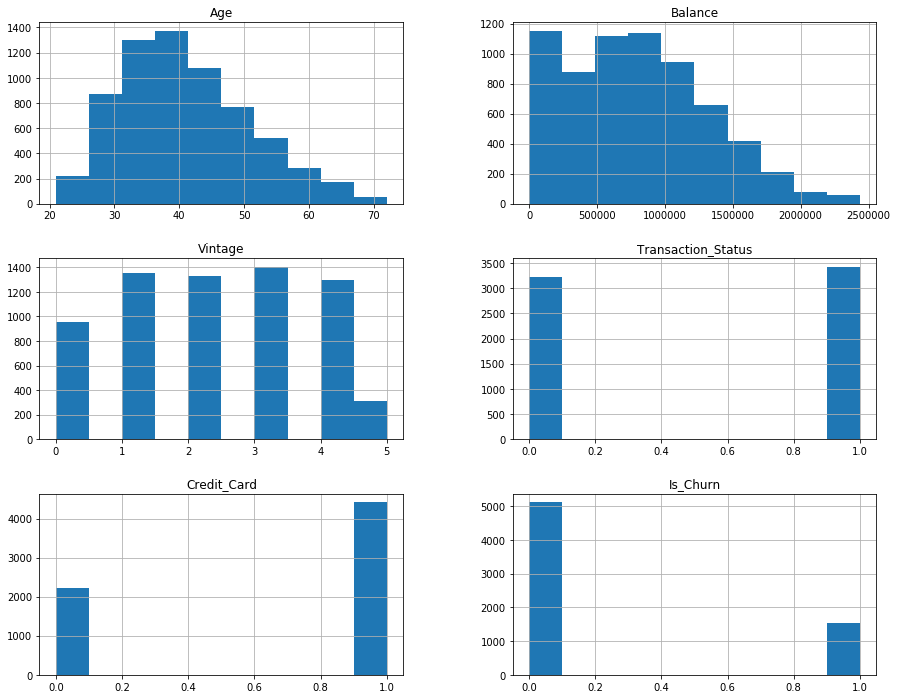

In [21]:
train.hist(figsize=(15,12));

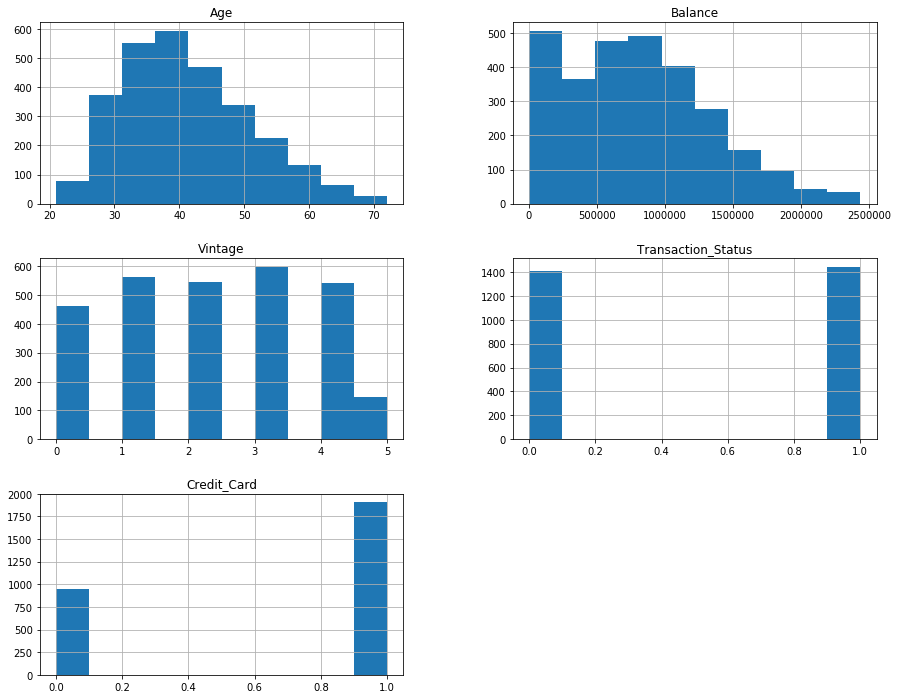

In [22]:
test.hist(figsize=(15,12));

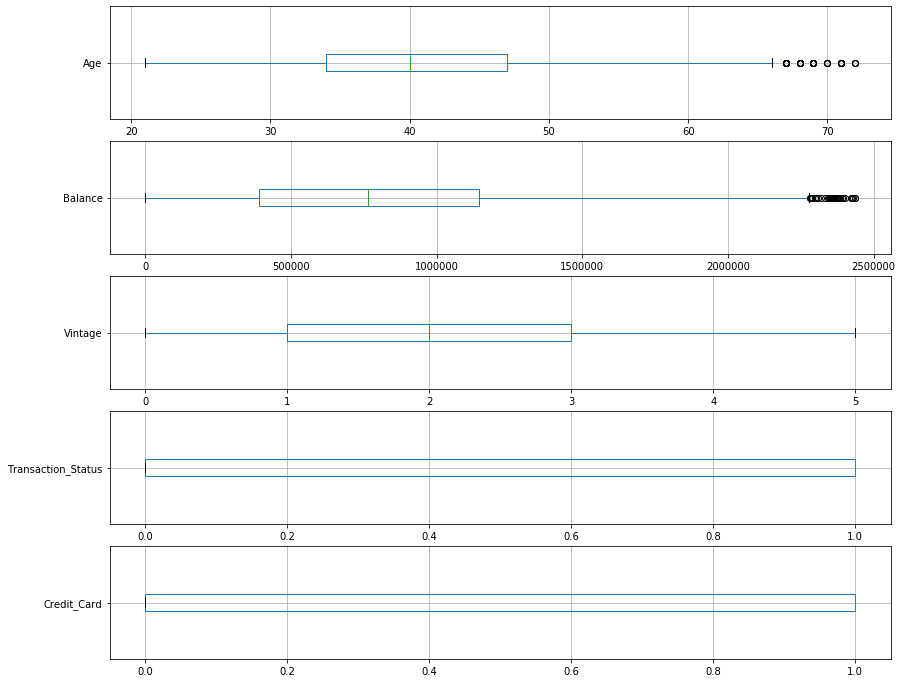

In [23]:

#Lets check boxplot distribution of numerical columns
fig,axes=plt.subplots(5,1,figsize=(14,12))
for i,c in enumerate(num_cols):
    _=train[[c]].boxplot(ax=axes[i],vert=False)

Age and Balance column have some outliers

In [24]:
train.describe()

,Age,Balance,Vintage,Transaction_Status,Credit_Card,Is_Churn
count,6650.000000,6.650000e+03,6650.000000,6650.000000,6650.000000,6650.000000
mean,41.130226,8.045954e+05,2.250226,0.515789,0.664361,0.231128
std,9.685747,5.157549e+05,1.458795,0.499788,0.472249,0.421586
min,21.000000,6.300000e+01,0.000000,0.000000,0.000000,0.000000
25%,34.000000,3.922642e+05,1.000000,0.000000,0.000000,0.000000
50%,40.000000,7.649386e+05,2.000000,1.000000,1.000000,0.000000
75%,47.000000,1.147124e+06,3.000000,1.000000,1.000000,0.000000
max,72.000000,2.436616e+06,5.000000,1.000000,1.000000,1.000000


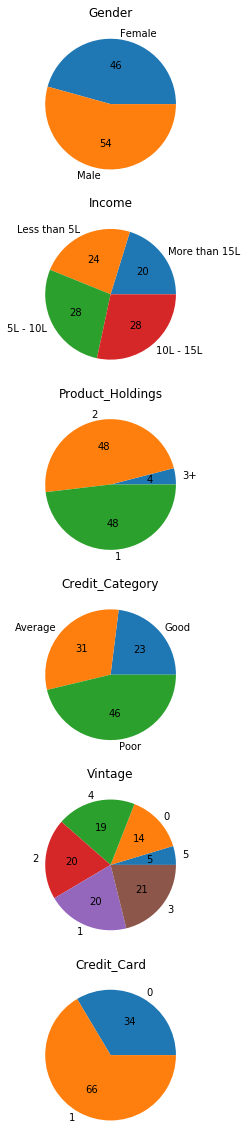

In [25]:
fig,axes=plt.subplots(6,1,figsize=(20,16))
for i,c in enumerate(cat_cols+['Vintage','Credit_Card']):
    _=train[c].value_counts()[::-1].plot(kind='pie',ax=axes[i],title=c,autopct='%.0f')
    _=axes[i].set_ylabel('')
plt.tight_layout()


In [26]:
train['Is_Churn'].value_counts()

0    5113
1    1537
Name: Is_Churn, dtype: int64

#### Bivariate analysis 

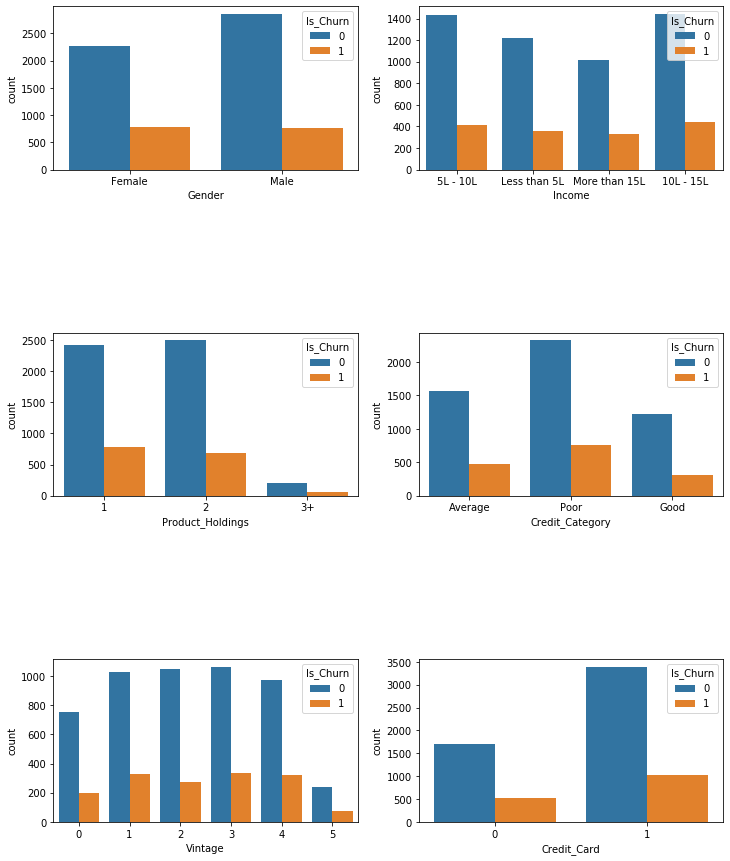

In [27]:
fig,axes=plt.subplots(3,2,figsize=(12,15))
for idx,cat_col in enumerate(cat_cols+['Vintage','Credit_Card']):
    row,col=idx//2,idx%2
    sns.countplot(x=cat_col,data=df_train,hue='Is_Churn',ax=axes[row,col])
plt.subplots_adjust(hspace=1)

In [28]:
credit=pd.crosstab(df_train['Credit_Category'],df_train['Is_Churn'])


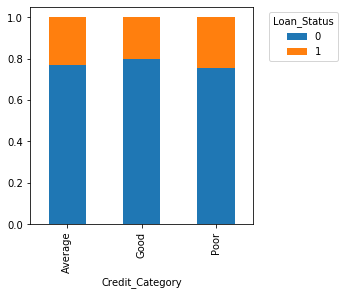

In [29]:
credit.div(credit.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,figsize=(4,4))
plt.legend(bbox_to_anchor=(1.05,1),title='Loan_Status')


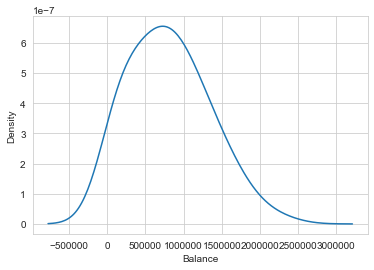

In [30]:
# Checking skewness of the Balance column

sns.set_style('whitegrid')
sns.kdeplot(train['Balance'], bw=0.5)
plt.show()


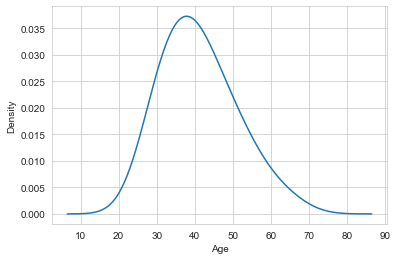

In [31]:
# Checking skewness of the Age column

sns.set_style('whitegrid')
sns.kdeplot(train['Age'], bw=0.5)
plt.show()


In [32]:
#Distribution of Age column
pd.DataFrame(train['Age'].describe(percentiles=(1,0.99,0.9,0.75,0.5,0.25,0.1,0.01)))

,Age
count,6650.000000
mean,41.130226
std,9.685747
min,21.000000
1%,24.000000
10%,29.000000
25%,34.000000
50%,40.000000
75%,47.000000
90%,55.000000


In [33]:
#Distribution of Balance
pd.DataFrame(train['Balance'].describe(percentiles=(1,0.99,0.9,0.75,0.5,0.25,0.1,0.01)))

,Balance
count,6.650000e+03
mean,8.045954e+05
std,5.157549e+05
min,6.300000e+01
1%,1.371933e+04
10%,1.298474e+05
25%,3.922642e+05
50%,7.649386e+05
75%,1.147124e+06
90%,1.511155e+06


In [34]:
train['Product_Holdings'].replace('3+',3,inplace=True)
test['Product_Holdings'].replace('3+',3,inplace=True)


In [35]:
train['Product_Holdings']=train['Product_Holdings'].astype('int64')

In [36]:
test['Product_Holdings']=test['Product_Holdings'].astype('int64')

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  6650 non-null   object 
 1   Age                 6650 non-null   int64  
 2   Gender              6650 non-null   object 
 3   Income              6650 non-null   object 
 4   Balance             6650 non-null   float64
 5   Vintage             6650 non-null   int64  
 6   Transaction_Status  6650 non-null   int64  
 7   Product_Holdings    6650 non-null   int64  
 8   Credit_Card         6650 non-null   int64  
 9   Credit_Category     6650 non-null   object 
 10  Is_Churn            6650 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 571.6+ KB


In [38]:
cat_cols.remove('Product_Holdings')

In [39]:
cat_cols

['Gender', 'Income', 'Credit_Category']

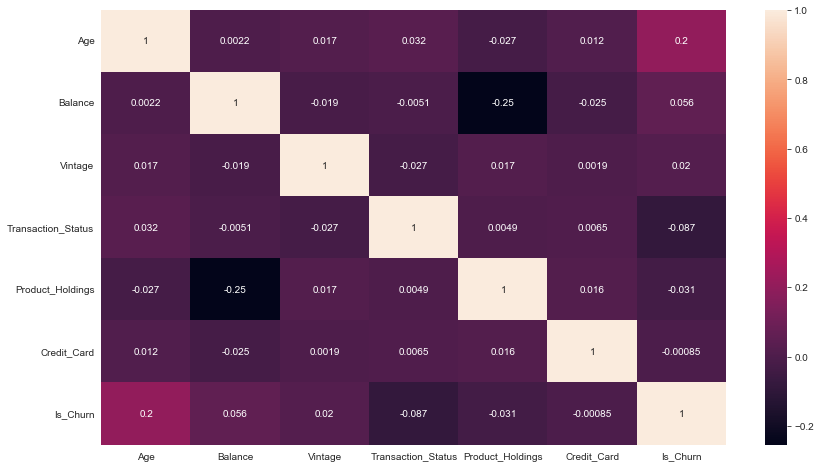

In [40]:
plt.figure(figsize=(14,8))
sns.heatmap(train.corr(),annot=True)

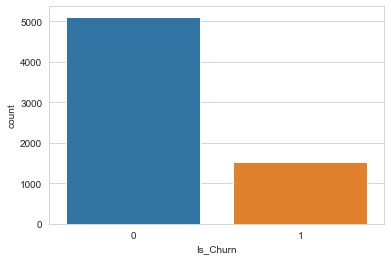

In [41]:
sns.countplot(train['Is_Churn'],data=train)

Text(0.5, 1.0, 'Age Distribution against churn event')

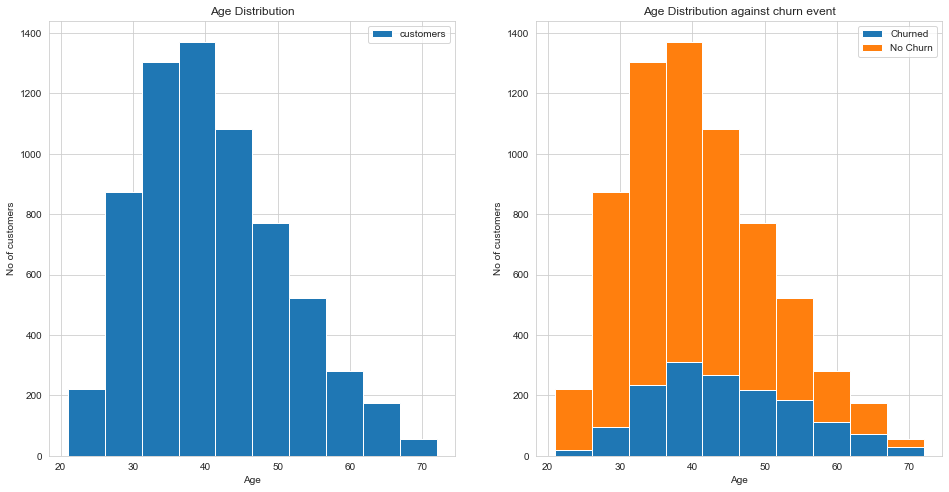

In [42]:
fig,ax=plt.subplots(1,2,figsize=(16,8))
ax[0].hist(train['Age'],label='customers')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('No of customers')
#ax[0].set_yticks([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75])
ax[0].legend()
ax[0].set_title('Age Distribution')
ax[1].hist(x=[train[train['Is_Churn']==1]['Age'],train[train['Is_Churn']==0]['Age']],stacked=True,label=['Churned','No Churn'])
ax[1].set_xlabel('Age')
ax[1].set_ylabel('No of customers')
#ax[1].set_yticks([5,10,15,20,25,30,35,40,45,50,55,60,65,70,5])
ax[1].legend()
ax[1].set_title('Age Distribution against churn event')


Text(0.5, 1.0, 'Balance Distribution against churn event')

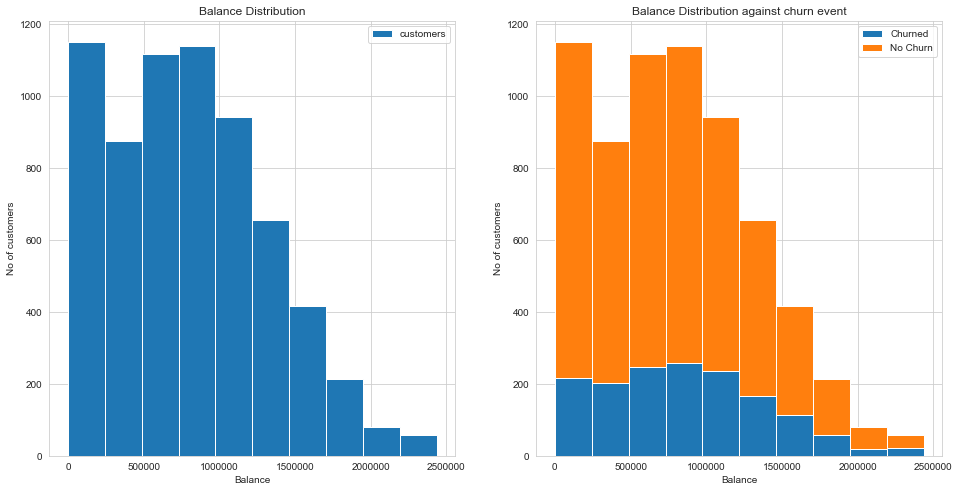

In [43]:
fig,ax=plt.subplots(1,2,figsize=(16,8))
ax[0].hist(train['Balance'],label='customers')
ax[0].set_xlabel('Balance')
ax[0].set_ylabel('No of customers')
ax[0].legend()
ax[0].set_title('Balance Distribution')
ax[1].hist(x=[train[train['Is_Churn']==1]['Balance'],train[train['Is_Churn']==0]['Balance']],stacked=True,label=['Churned','No Churn'])
ax[1].set_xlabel('Balance')
ax[1].set_ylabel('No of customers')
ax[1].legend()
ax[1].set_title('Balance Distribution against churn event')


Aged customers tend to churn more

In [44]:
train.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,84e2fcc9,36,Female,5L - 10L,563266.44,4,0,1,0,Average,1
1,57fea15e,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,0
2,8df34ef3,35,Female,More than 15L,701607.06,2,1,2,0,Poor,0
3,c5c0788b,43,Female,More than 15L,1393922.16,0,1,2,1,Poor,1
4,951d69c4,39,Female,More than 15L,893146.23,1,1,1,1,Good,1


In [45]:
train.Credit_Category.replace('Poor',1,inplace=True)
train.Credit_Category.replace('Average',5,inplace=True)
train.Credit_Category.replace('Good',10,inplace=True)


In [46]:
test.Credit_Category.replace('Poor',1,inplace=True)
test.Credit_Category.replace('Average',5,inplace=True)
test.Credit_Category.replace('Good',10,inplace=True)


In [47]:
#5L - 10L' 'Less than 5L' 'More than 15L' '10L - 15L'
train.Income.replace('Less than 5L',500000,inplace=True)
train.Income.replace('5L - 10L',1000000,inplace=True)
train.Income.replace('10L - 15L',1500000,inplace=True)
train.Income.replace('More than 15L',2000000,inplace=True)


In [48]:
test.Income.replace('Less than 5L',500000,inplace=True)
test.Income.replace('5L - 10L',1000000,inplace=True)
test.Income.replace('10L - 15L',1500000,inplace=True)
test.Income.replace('More than 15L',2000000,inplace=True)


In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  6650 non-null   object 
 1   Age                 6650 non-null   int64  
 2   Gender              6650 non-null   object 
 3   Income              6650 non-null   int64  
 4   Balance             6650 non-null   float64
 5   Vintage             6650 non-null   int64  
 6   Transaction_Status  6650 non-null   int64  
 7   Product_Holdings    6650 non-null   int64  
 8   Credit_Card         6650 non-null   int64  
 9   Credit_Category     6650 non-null   int64  
 10  Is_Churn            6650 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 571.6+ KB


In [50]:
train = pd.get_dummies(train, columns = ['Gender'],drop_first=True)

In [51]:
test = pd.get_dummies(test, columns = ['Gender'],drop_first=True)

In [52]:
train['bal_by_inc']=train['Balance']/(train['Income'])

In [53]:
test['bal_by_inc']=test['Balance']/(test['Income'])

In [54]:
train['bal_vint']=train['Balance']*((train['Vintage']*4)+2)

In [55]:
test['bal_vint']=test['Balance']*((test['Vintage']*4)+2)

In [56]:
train['bal_by_age']=train['Balance']/train['Age']
test['bal_by_age']=test['Balance']/test['Age']

In [57]:
train['inc_by_age']=train['Income']/train['Age']
test['inc_by_age']=test['Income']/test['Age']

In [58]:
train['Product_card']=train['Product_Holdings']+train['Credit_Card']

In [59]:
test['Product_card']=test['Product_Holdings']+test['Credit_Card']

In [60]:
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]

In [61]:
train.head()

,ID,Age,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn,Gender_Male,bal_by_inc,bal_vint,bal_by_age,inc_by_age,Product_card
0,84e2fcc9,36,1000000,563266.44,4,0,1,0,5,1,0,0.563266,10138795.92,15646.290000,27777.777778,1
1,57fea15e,53,500000,875572.11,2,1,1,1,1,0,0,1.751144,8755721.10,16520.228491,9433.962264,2
2,8df34ef3,35,2000000,701607.06,2,1,2,0,1,0,0,0.350804,7016070.60,20045.916000,57142.857143,2
3,c5c0788b,43,2000000,1393922.16,0,1,2,1,1,1,0,0.696961,2787844.32,32416.794419,46511.627907,3
4,951d69c4,39,2000000,893146.23,1,1,1,1,10,1,0,0.446573,5358877.38,22901.185385,51282.051282,2


In [62]:
features

['Age',
 'Income',
 'Balance',
 'Vintage',
 'Transaction_Status',
 'Product_Holdings',
 'Credit_Card',
 'Credit_Category',
 'Gender_Male',
 'bal_by_inc',
 'bal_vint',
 'bal_by_age',
 'inc_by_age',
 'Product_card']

In [63]:
train.head()

,ID,Age,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn,Gender_Male,bal_by_inc,bal_vint,bal_by_age,inc_by_age,Product_card
0,84e2fcc9,36,1000000,563266.44,4,0,1,0,5,1,0,0.563266,10138795.92,15646.290000,27777.777778,1
1,57fea15e,53,500000,875572.11,2,1,1,1,1,0,0,1.751144,8755721.10,16520.228491,9433.962264,2
2,8df34ef3,35,2000000,701607.06,2,1,2,0,1,0,0,0.350804,7016070.60,20045.916000,57142.857143,2
3,c5c0788b,43,2000000,1393922.16,0,1,2,1,1,1,0,0.696961,2787844.32,32416.794419,46511.627907,3
4,951d69c4,39,2000000,893146.23,1,1,1,1,10,1,0,0.446573,5358877.38,22901.185385,51282.051282,2


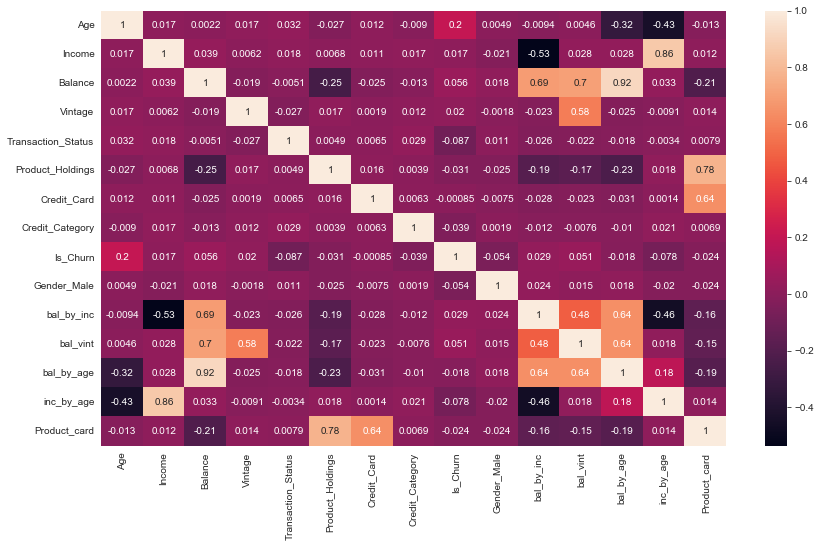

In [64]:
plt.figure(figsize=(14,8))
sns.heatmap(train.corr(),annot=True)

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  6650 non-null   object 
 1   Age                 6650 non-null   int64  
 2   Income              6650 non-null   int64  
 3   Balance             6650 non-null   float64
 4   Vintage             6650 non-null   int64  
 5   Transaction_Status  6650 non-null   int64  
 6   Product_Holdings    6650 non-null   int64  
 7   Credit_Card         6650 non-null   int64  
 8   Credit_Category     6650 non-null   int64  
 9   Is_Churn            6650 non-null   int64  
 10  Gender_Male         6650 non-null   uint8  
 11  bal_by_inc          6650 non-null   float64
 12  bal_vint            6650 non-null   float64
 13  bal_by_age          6650 non-null   float64
 14  inc_by_age          6650 non-null   float64
 15  Product_card        6650 non-null   int64  
dtypes: flo

In [66]:
train1=train.copy()

In [67]:
train=train.drop(['Product_Holdings','Credit_Card'],axis=1)

In [68]:
test=test.drop(['Product_Holdings','Credit_Card'],axis=1)

In [69]:
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]

In [70]:
X = train.drop(['Is_Churn','ID'],axis='columns')
y = train['Is_Churn']

In [71]:
y.value_counts()

0    5113
1    1537
Name: Is_Churn, dtype: int64

In [72]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

y_sm.value_counts()


1    5113
0    5113
Name: Is_Churn, dtype: int64

In [73]:
train_sm=pd.concat([X_sm,y_sm],axis=1)

In [74]:
train_sm

,Age,Income,Balance,Vintage,Transaction_Status,Credit_Category,Gender_Male,bal_by_inc,bal_vint,bal_by_age,inc_by_age,Product_card,Is_Churn
0,36,1000000,5.632664e+05,4,0,5,0,0.563266,1.013880e+07,15646.290000,27777.777778,1,1
1,53,500000,8.755721e+05,2,1,1,0,1.751144,8.755721e+06,16520.228491,9433.962264,2,0
2,35,2000000,7.016071e+05,2,1,1,0,0.350804,7.016071e+06,20045.916000,57142.857143,2,0
3,43,2000000,1.393922e+06,0,1,1,0,0.696961,2.787844e+06,32416.794419,46511.627907,3,1
4,39,2000000,8.931462e+05,1,1,10,0,0.446573,5.358877e+06,22901.185385,51282.051282,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10221,42,1688306,1.081758e+06,4,0,2,0,0.653348,1.947164e+07,27765.371379,45235.837484,1,1
10222,39,500000,7.394571e+05,2,1,2,0,1.478914,7.394571e+06,19883.971268,13410.135136,2,1
10223,40,2000000,7.344872e+05,4,0,8,0,0.367244,1.322077e+07,18237.306597,49615.434055,2,1
10224,43,1500000,7.887410e+05,0,0,1,0,0.525827,1.577482e+06,17972.212122,34180.530779,1,1


In [75]:
target = train_sm[TARGET_COL]

In [76]:
def run_clf_kfold(clf, train, test, features):

    N_SPLITS = 10

    oofs = np.zeros(len(train))
    preds = np.zeros((len(test)))
    feature_importances=pd.DataFrame()
    

    folds = StratifiedKFold(n_splits = N_SPLITS)

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
        print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
        ### Training Set
        X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

        ### Validation Set
        X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

        ### Test Set
        X_test = test[features]

        ############# Scaling Data ################
        scaler = StandardScaler()
        _ = scaler.fit(X_trn)

        X_trn = scaler.transform(X_trn)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)


        ############# Fitting and Predicting ################

        _ = clf.fit(X_trn, y_trn)
        fold_importance=pd.DataFrame({'fold':fold_+1,'feature':features,'importance':clf.feature_importances_})
        
        feature_importances=pd.concat([feature_importances,fold_importance],axis=0)


        ### Instead of directly predicting the classes we will obtain the probability of positive class.
        preds_val = clf.predict_proba(X_val)[:, 1]
        preds_test = clf.predict_proba(X_test)[:, 1]

        fold_score = f1_score(y_val, preds_val.round())
        print(f'\nF1 score for validation set is {fold_score}')

        oofs[val_idx] = preds_val
        preds += preds_test / N_SPLITS

    oofs_score = f1_score(target, oofs.round())
    print(f'\n\nF1 score for oofs is {oofs_score}')

    feature_importances=feature_importances.reset_index(drop=True)
    fi=feature_importances.groupby('feature')['importance'].mean().sort_values(ascending=False)[:20][::-1]
    fi.plot(kind='barh',figsize=(14,8))
   
    return oofs, preds,fi

In [77]:
def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COL] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)


In [78]:
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]

In [79]:
features

['Age',
 'Income',
 'Balance',
 'Vintage',
 'Transaction_Status',
 'Credit_Category',
 'Gender_Male',
 'bal_by_inc',
 'bal_vint',
 'bal_by_age',
 'inc_by_age',
 'Product_card']


------------- Fold 1 -------------

F1 score for validation set is 0.4862023653088043

------------- Fold 2 -------------

F1 score for validation set is 0.39095744680851063

------------- Fold 3 -------------

F1 score for validation set is 0.4396782841823056

------------- Fold 4 -------------

F1 score for validation set is 0.8639391056137012

------------- Fold 5 -------------

F1 score for validation set is 0.8684210526315789

------------- Fold 6 -------------

F1 score for validation set is 0.865979381443299

------------- Fold 7 -------------

F1 score for validation set is 0.8723599632690542

------------- Fold 8 -------------

F1 score for validation set is 0.8767908309455588

------------- Fold 9 -------------

F1 score for validation set is 0.8691499522445081

------------- Fold 10 -------------

F1 score for validation set is 0.8713060057197332


F1 score for oofs is 0.7691512457355526


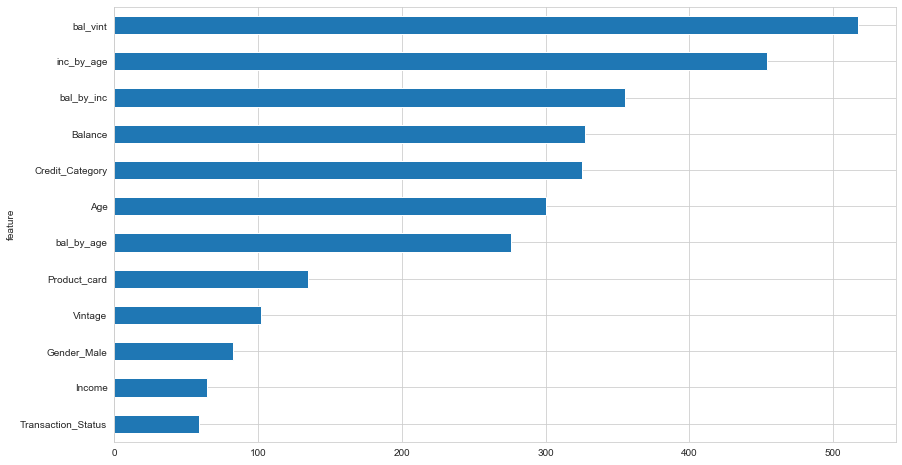

In [80]:
clf = LGBMClassifier(random_state=123)
lgb_oofs, lgb_preds,fi = run_clf_kfold(clf, train_sm, test, features)

In [81]:
lg_preds_rounded = lgb_preds.round()

In [82]:
download_preds(lg_preds_rounded, file_name = 'lg_sm_folds.csv')

In [83]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 123,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [84]:
def run_gradient_boosting(clf,fit_params, train, test, features):

    N_SPLITS = 10

    oofs = np.zeros(len(train))
    preds = np.zeros((len(test)))
    feature_importances=pd.DataFrame()
    

    folds = StratifiedKFold(n_splits = N_SPLITS)

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
        print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
        ### Training Set
        X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

        ### Validation Set
        X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

        ### Test Set
        X_test = test[features]

        ############# Scaling Data ################
        scaler = StandardScaler()
        _ = scaler.fit(X_trn)

        X_trn = scaler.transform(X_trn)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)


        ############# Fitting and Predicting ################

        _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)
            
        fold_importance=pd.DataFrame({'fold':fold_+1,'feature':features,'importance':clf.feature_importances_})
        
        feature_importances=pd.concat([feature_importances,fold_importance],axis=0)


        ### Instead of directly predicting the classes we will obtain the probability of positive class.
        preds_val = clf.predict_proba(X_val)[:, 1]
        preds_test = clf.predict_proba(X_test)[:, 1]

        fold_score = f1_score(y_val, preds_val.round())
        print(f'\nF1 score for validation set is {fold_score}')

        oofs[val_idx] = preds_val
        preds += preds_test / N_SPLITS

    oofs_score = f1_score(target, oofs.round())
    print(f'\n\nF1 score for oofs is {oofs_score}')

    feature_importances=feature_importances.reset_index(drop=True)
    fi=feature_importances.groupby('feature')['importance'].mean().sort_values(ascending=False)[:20][::-1]
    fi.plot(kind='barh',figsize=(14,8))
   
    return oofs, preds,fi


------------- Fold 1 -------------
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.76 will be ignored. Current value: feature_fraction=0.7
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.665165
[200]	valid_0's binary_logloss: 0.673408
[300]	valid_0's binary_logloss: 0.681549
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.664917

F1 score for validation set is 0.44090305444887123

------------- Fold 2 -------------
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.76 will be ignored. Current value: feature_fraction=0.7
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.693979
[200]	valid_0's binary_logloss: 0.719008
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.685008

F1 score for validation set is 0.3671232876

[200]	valid_0's binary_logloss: 0.441034
[300]	valid_0's binary_logloss: 0.410396
[400]	valid_0's binary_logloss: 0.391927
[500]	valid_0's binary_logloss: 0.37944
[600]	valid_0's binary_logloss: 0.37098
[700]	valid_0's binary_logloss: 0.362035
[800]	valid_0's binary_logloss: 0.354082
[900]	valid_0's binary_logloss: 0.347049
[1000]	valid_0's binary_logloss: 0.341649
[1100]	valid_0's binary_logloss: 0.336802
[1200]	valid_0's binary_logloss: 0.333272
[1300]	valid_0's binary_logloss: 0.329908
[1400]	valid_0's binary_logloss: 0.326663
[1500]	valid_0's binary_logloss: 0.32366
[1600]	valid_0's binary_logloss: 0.320241
[1700]	valid_0's binary_logloss: 0.317858
[1800]	valid_0's binary_logloss: 0.315645
[1900]	valid_0's binary_logloss: 0.312818
[2000]	valid_0's binary_logloss: 0.311188
[2100]	valid_0's binary_logloss: 0.308852
[2200]	valid_0's binary_logloss: 0.307052
[2300]	valid_0's binary_logloss: 0.305073
[2400]	valid_0's binary_logloss: 0.30312
[2500]	valid_0's binary_logloss: 0.301066
[260

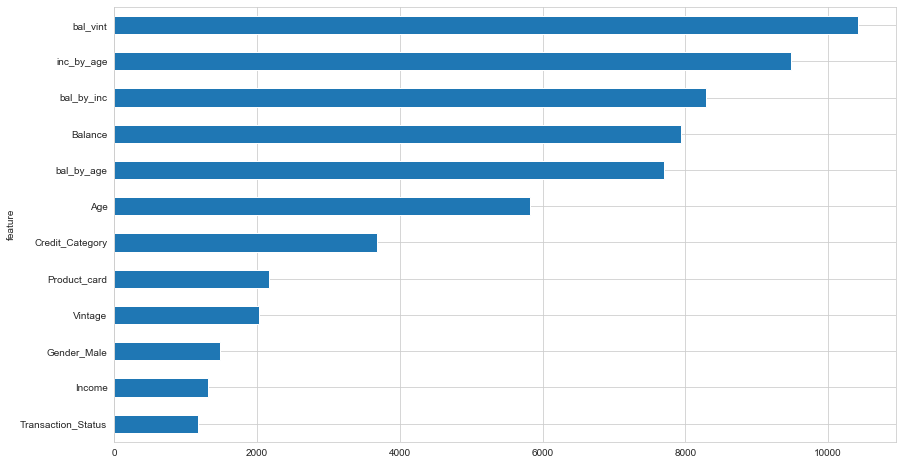

In [85]:
clf = LGBMClassifier(n_estimators = 3000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.76,
                      sub_sample=0.2,
                      max_depth=20,
                     feature_fraction=0.7,
                     num_leaves=30,
                     
                        )
fit_params = {'verbose': 100, 'early_stopping_rounds': 200}

lgb_oofs, lgb_preds,fi = run_gradient_boosting(clf, fit_params, train_sm, test, features)



In [86]:
lg_preds_rounded = lgb_preds.round()

In [87]:
download_preds(lg_preds_rounded, file_name = 'lg_gb_folds.csv')


------------- Fold 1 -------------
[20:33:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.67101
[99]	validation_0-logloss:0.73165

F1 score for validation set is 0.5255813953488373

------------- Fold 2 -------------
[20:33:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.68412
[99]	validation_0-logloss:0.86154

F1 score for validation set is 0.5021739130434782

------------- Fold 3 -------------
[20:33:10] WARNING: C:/Users/Adminis

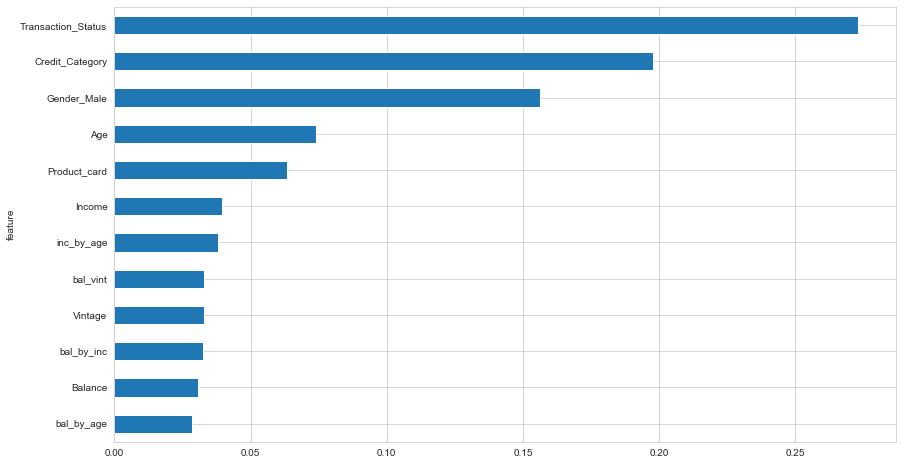

In [88]:
xgclf = XGBClassifier()
fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds,fi = run_gradient_boosting(xgclf, fit_params, train_sm, test, features)


In [89]:
xg_preds_rounded = xgb_preds.round()
download_preds(xg_preds_rounded, file_name = 'xg_gb_folds.csv')


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds
[200]	valid_0's binary_logloss: 0.651052
Did not meet early stopping. Best iteration is:
[235]	valid_0's binary_logloss: 0.65013

F1 score for validation set is 0.4973958333333333

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds
[200]	valid_0's binary_logloss: 0.683354
Did not meet early stopping. Best iteration is:
[113]	valid_0's binary_logloss: 0.678644

F1 score for validation set is 0.4089121887287025

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds
[200]	valid_0's binary_logloss: 0.656351
Did not meet early stopping. Best iteration is:
[226]	valid_0's binary_logloss: 0.65595

F1 score for validation set is 0.45623342175066317

------------- Fold 4 -------------
Training until validation scores don't improve for 200 rounds
[200]	valid_0's binary_logloss: 0.492816
Did not meet early stoppi

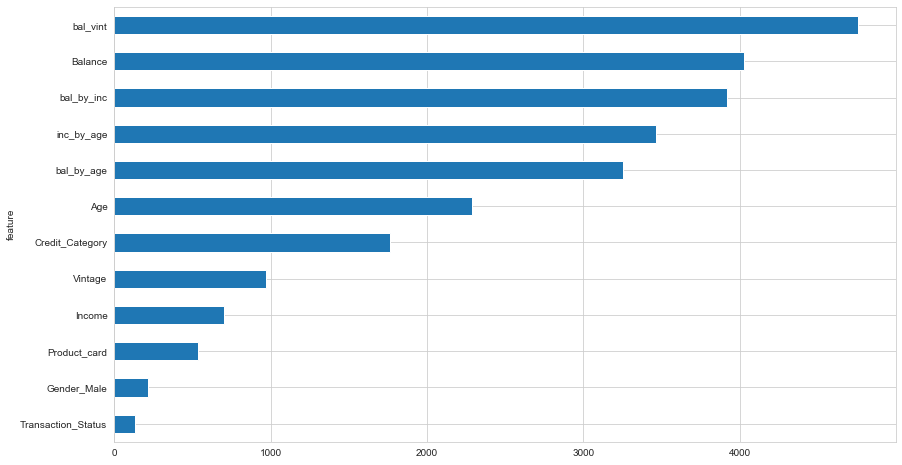

In [90]:
params={'n_estimators': 307, 'max_depth': 9, 'learning_rate': 0.005595292515677793, 'colsample_bytree': 0.4806096956630678, 'num_leaves': 102, 'reg_alpha': 0.1333071812752145, 'reg_lambda': 0.29319576912726125, 'min_split_gain': 0.9026464560760671, 'subsample': 0.4637884686630859}

lgclf=LGBMClassifier(**params)
fit_params = {'verbose': 200, 'early_stopping_rounds': 200}
lgb_oofs, lgb_preds,fi = run_gradient_boosting(lgclf, fit_params, train_sm, test, features)


In [91]:
lg_preds_rounded = lgb_preds.round()

In [92]:
download_preds(lg_preds_rounded, file_name = 'lgb_optun.csv')

In [93]:
from sklearn.ensemble import VotingClassifier

In [94]:
lg_clf=LGBMClassifier()
xg_clf=XGBClassifier()


In [95]:
vot_clf = VotingClassifier(estimators = [('lg', lg_clf), ('xg', xg_clf)], voting = 'soft')


In [96]:
def run_vot_kfold(clf, train, test, features):

    N_SPLITS = 10

    oofs = np.zeros(len(train))
    preds = np.zeros((len(test)))
    #feature_importances=pd.DataFrame()
    

    folds = StratifiedKFold(n_splits = N_SPLITS)

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
        print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
        ### Training Set
        X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

        ### Validation Set
        X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

        ### Test Set
        X_test = test[features]

        ############# Scaling Data ################
        scaler = StandardScaler()
        _ = scaler.fit(X_trn)

        X_trn = scaler.transform(X_trn)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)


        ############# Fitting and Predicting ################

        _ = clf.fit(X_trn, y_trn)
        #fold_importance=pd.DataFrame({'fold':fold_+1,'feature':features,'importance':clf.feature_importances_})
        
        #feature_importances=pd.concat([feature_importances,fold_importance],axis=0)


        ### Instead of directly predicting the classes we will obtain the probability of positive class.
        preds_val = clf.predict_proba(X_val)[:, 1]
        preds_test = clf.predict_proba(X_test)[:, 1]

        fold_score = f1_score(y_val, preds_val.round())
        print(f'\nF1 score for validation set is {fold_score}')

        oofs[val_idx] = preds_val
        preds += preds_test / N_SPLITS

    oofs_score = f1_score(target, oofs.round())
    print(f'\n\nF1 score for oofs is {oofs_score}')

    #feature_importances=feature_importances.reset_index(drop=True)
    #fi=feature_importances.groupby('feature')['importance'].mean().sort_values(ascending=False)[:20][::-1]
    #fi.plot(kind='barh',figsize=(14,8))
   
    return oofs, preds

In [97]:
vt_oofs, vt_preds = run_vot_kfold(vot_clf, train_sm, test, features)


------------- Fold 1 -------------
[20:33:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

F1 score for validation set is 0.4902216427640157

------------- Fold 2 -------------
[20:33:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

F1 score for validation set is 0.40854472630173566

------------- Fold 3 -------------
[20:33:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with 

In [98]:
vt_preds_rounded = vt_preds.round()
download_preds(vt_preds_rounded, file_name = 'voting_tuned.csv')